In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import h5py
from pathlib import Path

from sklearn.linear_model import Ridge,Lasso
from sklearn.decomposition import PCA

#from scipy.signal import find_peaks
#from scipy.cluster import hierarchy

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import flammkuchen as fl

In [3]:
from megabouts.tracking_data import TrackingConfig,load_example_data,FullTrackingData
from megabouts.config import TailPreprocessingConfig,TrajPreprocessingConfig
from megabouts.preprocessing import TailPreprocessing,TrajPreprocessing
from megabouts.config import TailSegmentationConfig
from megabouts.segmentation import SegmentationResult
from megabouts.classification import TailBouts,BoutClassifier
from megabouts.utils import bouts_category_color,bouts_category_name_short, bouts_category_name

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
labels_cat = ['approach_swim',
 'slow1',
 'slow2',
 'burst_swim',
 'J_turn',
 'high_angle_turn',
 'routine_turn',
 'spot_avoidance_turn',
 'O_bend',
 'long_latency_C_start',
 'C_start']

color =  ['#82cfff',
  '#4589ff',
  '#0000c8',
  '#fcaf6d',
  '#ffb3b8',
  '#08bdba',
  '#24a148',
  '#9b82f3',
  '#ee5396',
  '#e3bc13',
  '#fa4d56']

In [6]:
bouts_category_name_short, bouts_category_name

(['AS',
  'S1',
  'S2',
  'SCS',
  'LCS',
  'BS',
  'JT',
  'HAT',
  'RT',
  'SAT',
  'O',
  'LLC',
  'SLC'],
 ['approach_swim',
  'slow1',
  'slow2',
  'short_capture_swim',
  'long_capture_swim',
  'burst_swim',
  'J_turn',
  'high_angle_turn',
  'routine_turn',
  'spot_avoidance_turn',
  'O_bend',
  'long_latency_C_start',
  'short_latency_C_start'])

# Load Bouts

In [7]:
# f = h5py.File('H://KathaDataset//Angle_tensors_dynamic_systems//KK_angles_tensor.h5')
# f = h5py.File(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data\KK_angles_tensor.h5')
# f = h5py.File(r"\\portulab.synology.me\data\Kata\Processed_Data\tensor_data\tensors\KK_angles_tensor.h5")

master_path = Path(r'/Users/katharinakotter/Desktop/Processed_Data/tensor_data')
f = h5py.File(master_path/ 'tensors'/'KK_angles_tensor_full.h5')
# f = h5py.File(r"\\portulab.synology.me\data\Kata\Processed_Data\tensor_data\tensors\keypoint_angles_tensor.h5")

#save_figure_path = Path(r'\\portulab.synology.me\data\Kata\Figures_Paper')
save_figure_path = Path(r'/Users/katharinakotter/Desktop/Figures_Paper')

In [8]:
path_features = Path(master_path/ 'features'/'features.csv')
features = pd.read_csv(path_features)
features.head()

,Unnamed: 0,exp,fish_id,bout_angle,cluster,frame_start,frame_end,bout_id_orig,mb_outlier,mb_proba,...,r_wf_cD_18,r_wf_cD_19,r_wf_cD_20,r_wf_cD_21,r_wf_cD_22,r_wf_cD_23,r_wf_cD_24,r_wf_cD_25,r_wf_cD_26,manual_filter
0,0,13052024_visstim_2D_round,240513_f0,3.000171,0.0,18375,18410,78,1.526243,0.806645,...,0.006377,-0.045620,0.007518,0.013329,0.004726,0.000998,0.008791,-0.020378,0.005320,True
1,1,13052024_visstim_2D_round,240513_f0,1.649302,0.0,19461,19484,80,1.272929,1.000000,...,0.004050,0.001662,0.006292,-0.003457,0.010940,-0.004363,-0.004270,0.010013,-0.003858,True
2,2,13052024_visstim_2D_round,240513_f0,-0.861132,0.0,19661,19689,81,1.381107,1.000000,...,0.002266,-0.011402,0.001642,0.013430,0.002027,0.001464,0.005703,-0.011803,0.005990,True
3,3,13052024_visstim_2D_round,240513_f0,0.870591,0.0,20257,20292,84,1.379946,1.000000,...,-0.054748,-0.003259,0.031659,-0.014441,-0.007220,0.004716,0.003047,-0.006476,0.003232,True
4,4,13052024_visstim_2D_round,240513_f0,2.231631,0.0,20824,20859,86,1.592415,1.000000,...,-0.006264,-0.012003,0.013543,0.011691,-0.011736,-0.010664,0.006758,-0.010700,0.007576,True


In [9]:
features_new = pd.read_csv(master_path/ 'features_bouts_new.csv')
features_new.head()

,Unnamed: 0,exp,fish_id,bout_angle,cluster,frame_start,frame_end,bout_id_orig,max_eye_rot,max_eye_vergence,...,fin_fin_lag,ipsi_fin,leading_fin,tail_freq,l_fin_freqs,r_fin_freqs,l_start,l_end,r_start,r_end
0,0,13052024_visstim_2D_round,240513_f0,3.000171,0,18375,18410,78,-0.239648,0.017505,...,-4,0.0,1,24.324324,21.052632,21.951220,3.0,41.0,0.0,37.0
1,1,13052024_visstim_2D_round,240513_f0,1.649302,0,19461,19484,80,0.479035,0.016159,...,-4,0.0,1,11.627907,23.529412,23.809524,2.0,44.0,1.0,26.0
2,2,13052024_visstim_2D_round,240513_f0,-0.861132,0,19661,19689,81,-1.120168,0.011039,...,-4,0.0,1,19.512195,23.076923,20.833333,4.0,30.0,0.0,27.0
3,3,13052024_visstim_2D_round,240513_f0,0.870591,0,20257,20292,84,-2.662451,0.032388,...,4,0.0,0,22.857143,23.529412,23.529412,3.0,41.0,6.0,40.0
4,4,13052024_visstim_2D_round,240513_f0,2.231631,0,20824,20859,86,-1.192489,-0.001899,...,-4,0.0,0,21.621622,23.333333,20.689655,3.0,46.0,6.0,35.0


In [10]:
clusters_pre = features.cluster
np.unique(clusters_pre)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [11]:
# clusters = fl.load(r"\\portulab.synology.me\data\Kata\Processed_Data\tensor_data\features\KK_mb_clusters.h5")
clusters = fl.load(master_path /'features'/'KK_mb_clusters_full.h5')
clusters.shape

(11063,)

In [12]:
f['data']

<HDF5 dataset "data": shape (11063, 15, 50), type "<f8">

In [13]:
N = f['data'].shape[0]
print (N)
fps = 200

body = f['data'][:,0,:]
left_eye = f['data'][:,1,:]
right_eye = f['data'][:,2,:]
left_fin = f['data'][:,3,:]
right_fin = f['data'][:,4,:]
tail = np.cumsum(f['data'][:,5:,:],axis=1)

11063


In [14]:
tail.shape

(11063, 10, 50)

In [15]:
# i = np.random.randint(N)
# plt.plot(tail[i,:,:].T)
# plt.show()
# plt.plot(180/np.pi*body[i,:])
# plt.show()
# plt.plot(180/np.pi*left_fin[i,:],'k')
# plt.plot(180/np.pi*right_fin[i,:],'r')
# plt.show()

# Apply Megabouts Classification to original dataset

In [16]:
tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')
segmentation_cfg = TailSegmentationConfig(fps=fps)

In [17]:
tail_array = np.copy(tail)
traj_array = np.zeros((N,3,50))*np.nan
#traj_array[:,2,:] = body

In [18]:
tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')
segmentation_cfg = TailSegmentationConfig(fps=fps)
classifier = BoutClassifier(tracking_cfg,segmentation_cfg,exclude_CS=True,device=device)
classif_results = classifier.run_classification(tail_array=tail_array,
                                                traj_array=traj_array)
cat = classif_results['cat']
subcat = classif_results['subcat']
sign = classif_results['sign']
proba = classif_results['proba']
first_half_beat = classif_results['first_half_beat']

/Users/katharinakotter/miniconda3/envs/megabouts/lib/python3.11/site-packages/megabouts/classification/classification.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t

In [19]:
classif_results['cat'].shape, tail.shape

((11063,), (11063, 10, 50))

In [24]:
left_eye.shape

(11063, 50)

In [ ]:
### calculate mid head 
def mid_head(df):
    right_eye_posterior_x =  df['right_eye_posterior'].values[:, 0].astype('float')
    right_eye_posterior_y =  df['right_eye_posterior'].values[:, 1].astype('float')
    right_eye_anterior_x =  df['right_eye_anterior'].values[:, 0].astype('float')
    right_eye_anterior_y =  df['right_eye_anterior'].values[:, 1].astype('float')

    left_eye_posterior_x =  df['left_eye_posterior'].values[:, 0].astype('float')
    left_eye_posterior_y =  df['left_eye_posterior'].values[:, 1].astype('float')
    left_eye_anterior_x =   df['left_eye_anterior'].values[:, 0].astype('float')
    left_eye_anterior_y =   df['left_eye_anterior'].values[:, 1].astype('float')

    left_mid_eye_y = (left_eye_anterior_y+left_eye_posterior_y)/2
    left_mid_eye_x = (left_eye_anterior_x+left_eye_posterior_x)/2

    right_mid_eye_x = (right_eye_anterior_x+right_eye_posterior_x)/2
    right_mid_eye_y = (right_eye_anterior_y+right_eye_posterior_y)/2

    mid_headx, mid_heady = midpoint(left_mid_eye_x,left_mid_eye_y, right_mid_eye_x, right_mid_eye_y) #xy left, xy right

    return mid_headx, mid_heady, left_mid_eye_x, left_mid_eye_y, right_mid_eye_x, right_mid_eye_y



In [25]:
### Save new data for tom
new_dict = {}
new_dict['tail'] = tail
new_dict['body'] = body
new_dict['left_eye'] = left_eye
new_dict['right_eye'] = right_eye
new_dict['left_fin'] = left_fin
new_dict['right_fin'] = right_fin
new_dict['cat'] = classif_results['cat']
new_dict['proba'] = classif_results['proba']
new_dict['subcat'] = classif_results['subcat']
new_dict['sign'] = classif_results['sign']
new_dict['first_half_beat'] = classif_results['first_half_beat']
new_dict['bout_angle'] = features_new.bout_angle
new_dict['ipsi_fin'] = features_new.ipsi_fin
print (new_dict.keys())

# Save the dictionary to an HDF5 file
with h5py.File(master_path /'KK_full_data.h5', 'w') as h5file:
    for key, value in new_dict.items():
        if isinstance(value, np.ndarray):
            h5file.create_dataset(key, data=value)
        elif isinstance(value, (int, float, str, bytes)):
            h5file.attrs[key] = value
        else:
            # Convert other types to strings or handle accordingly
            h5file.attrs[key] = str(value)

print("Dictionary saved successfully")

dict_keys(['tail', 'body', 'left_eye', 'right_eye', 'left_fin', 'right_fin', 'cat', 'proba', 'subcat', 'sign', 'first_half_beat', 'bout_angle', 'ipsi_fin'])
Dictionary saved successfully


(array([  52.,  187.,  575.,  639.,  760.,  763.,  841., 1050., 1634.,
        4562.]),
 array([0.33092049, 0.39769769, 0.46447489, 0.5312521 , 0.5980293 ,
        0.6648065 , 0.7315837 , 0.79836091, 0.86513811, 0.93191531,
        0.99869251]),
 <BarContainer object of 10 artists>)

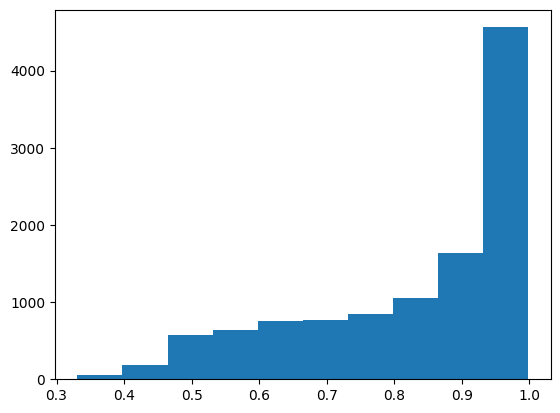

In [22]:
plt.figure()
plt.hist(proba)

In [58]:
classif_results

{'cat': array([0., 0., 0., ..., 8., 2., 8.]),
 'subcat': array([ 0.,  0.,  0., ..., 11.,  2., 11.]),
 'sign': array([-1, -1, -1, ...,  1,  1, -1]),
 'proba': array([0.93471855, 0.95473111, 0.93848825, ..., 0.70519131, 0.7963627 ,
        0.59957057]),
 'first_half_beat': array([9., 9., 9., ..., 7., 7., 7.])}

In [59]:
np.unique(classif_results['cat']), np.unique(classif_results['subcat'])

(array([ 0.,  1.,  2.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 array([ 0.,  1.,  2.,  7.,  8.,  9., 10., 11., 12., 13., 15., 16., 17.]))

### Compare old and new classification

In [60]:
clusters_new = classif_results['cat']
clusters_refined = classif_results['subcat']
clusters_pre = clusters #features.cluster
clusters_pre.shape, clusters_new.shape, clusters_refined.shape

((11063,), (11063,), (11063,))

In [61]:
# assuming clusters_pre and clusters_new are your list data
df = pd.DataFrame({'clusters_pre': clusters_pre, 'clusters_new': clusters_new})


In [62]:
## numbers have to be reassigned in old one to match names -> 
clusters_new_names = bouts_category_name
clusters_pre_names = labels_cat + ['None1', 'None2']

In [63]:
len(clusters_new_names), len(clusters_pre_names)

(13, 13)

In [64]:
translation_dict_new = {0: 'approach_swim', 1: 'slow1', 2: 'slow2', 3: 'short_capture_swim', 4: 'long_capture_swim', 5: 'burst_swim', 6: 'J_turn', 7: 'high_angle_turn', 
                        8: 'routine_turn', 9: 'spot_avoidance_turn', 10: 'O_bend', 11: 'long_latency_C_start', 12: 'short_latency_C_start'}
translation_dict_pre = {0: 'approach_swim', 1: 'slow1', 2: 'slow2', 3: 'burst_swim', 4: 'J_turn', 5: 'high_angle_turn', 6: 'routine_turn', 7: 'spot_avoidance_turn', 8: 'O_bend', 9: 'long_latency_C_start', 10: 'short_latency_C_start'}


In [65]:
# Convert dictionaries into dataframes
df_pre = pd.DataFrame(list(translation_dict_pre.items()),columns = ['Id_pre','Name']) 
df_new = pd.DataFrame(list(translation_dict_new.items()),columns = ['Id_new','Name'])

# Merge dataframes based on the 'Name' column
translation_matrix = pd.merge(df_pre, df_new, on='Name', how='outer')
final_df = translation_matrix.sort_values(by=['Id_pre'], ascending=True)
print(final_df)


    Id_pre                   Name  Id_new
2      0.0          approach_swim       0
10     1.0                  slow1       1
11     2.0                  slow2       2
3      3.0             burst_swim       5
0      4.0                 J_turn       6
4      5.0        high_angle_turn       7
7      6.0           routine_turn       8
12     7.0    spot_avoidance_turn       9
1      8.0                 O_bend      10
6      9.0   long_latency_C_start      11
9     10.0  short_latency_C_start      12
5      NaN      long_capture_swim       4
8      NaN     short_capture_swim       3


In [66]:
# test_old = clusters_pre[:5].values
# test_new = clusters_new[:5]


In [67]:
old_labels = []
new_labels = []

for i, j in zip(clusters_pre, clusters_new):
    old_labels.append(final_df['Name'][final_df['Id_pre']==i].values[0])
    new_labels.append(final_df['Name'][final_df['Id_new']==j].values[0])

In [68]:
def count_label_changes(old_labels, new_labels):
    # Make sure both lists have the same length
    assert len(old_labels) == len(new_labels), "Label lists are not the same length"
    
    # Initialize counters
    same_label_count = 0
    changed_label_count = 0
    
    # Loop through both lists simultaneously
    for old, new in zip(old_labels, new_labels):
        # Increase the appropriate counter
        if old == new:
            same_label_count += 1
        else:
            changed_label_count += 1
    
    return same_label_count, changed_label_count


same, changed = count_label_changes(old_labels, new_labels)
print(f'Same Labels: {same}, Changed Labels: {changed}')


Same Labels: 5762, Changed Labels: 5301


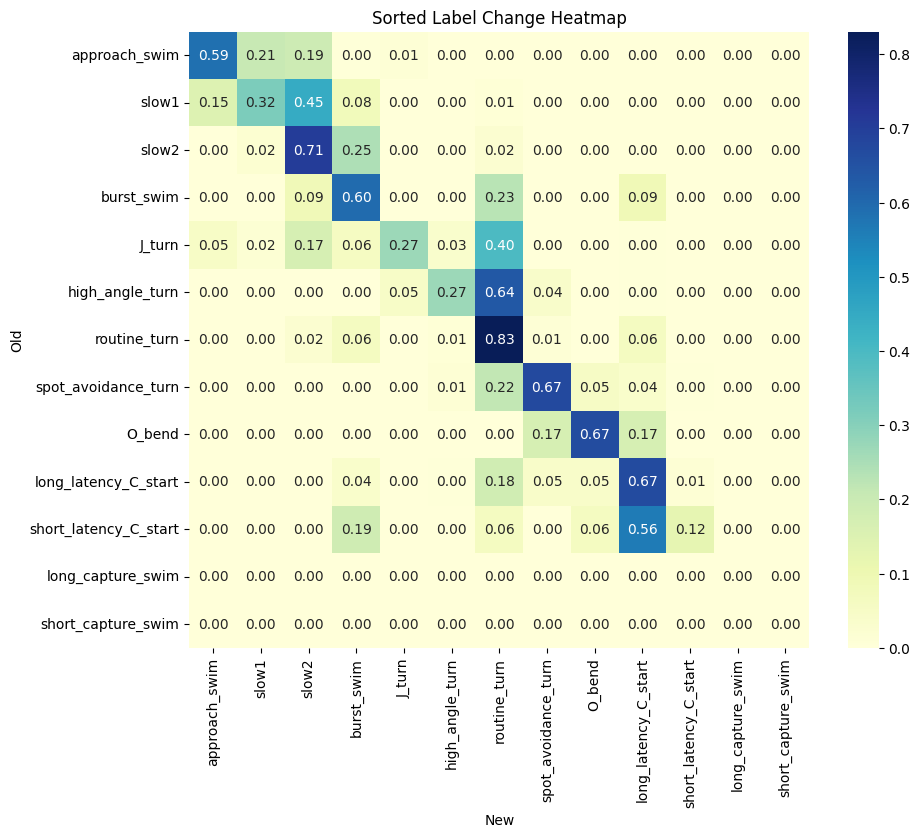

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_change_matrix(old_labels, new_labels):
    # Make sure both lists have the same length
    assert len(old_labels) == len(new_labels), "Label lists are not the same length"

    # Create a DataFrame to store changes
    df_changes = pd.DataFrame({'Old': old_labels, 'New': new_labels})

    # Create a pivot table with counts of changes
    change_matrix = df_changes.groupby(['Old', 'New']).size().unstack(fill_value=0)

    # Convert counts to percentages
    change_matrix = change_matrix.div(change_matrix.sum(axis=1), axis=0)

    return change_matrix

def plot_sorted_heatmap(change_matrix, final_df):
    # Sort the change_matrix based on the order in final_df
    sorted_labels = final_df['Name'].unique()
    change_matrix = change_matrix.reindex(index=sorted_labels, columns=sorted_labels, fill_value=0)

    # Plot a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(change_matrix, annot=True, fmt=".2f", cmap='YlGnBu')
    plt.title("Sorted Label Change Heatmap")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.savefig(Path( save_figure_path/ 'heatmap_megabouts_res.png'), dpi=350)
    

change_matrix = create_change_matrix(old_labels, new_labels)
plot_sorted_heatmap(change_matrix, final_df)



### Plot results

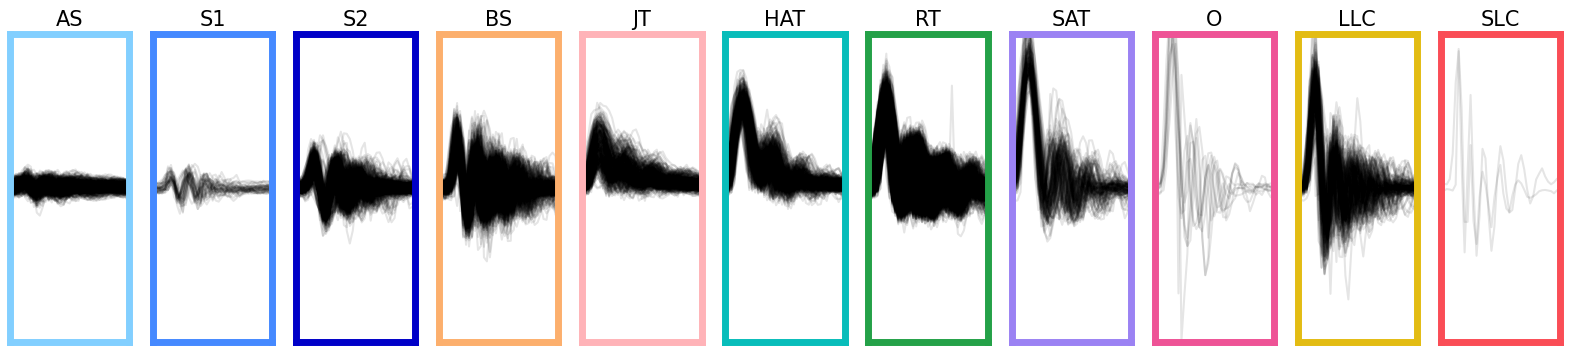

In [70]:
id_b = np.unique(cat[proba>0.8]).astype('int')

fig, ax = plt.subplots(facecolor='white',figsize=(20,4)) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
G = gridspec.GridSpec(1,len(id_b))
ax0 = {}
for i,b in enumerate(id_b):
    ax0 = plt.subplot(G[i])
    ax0.set_title(bouts_category_name_short[b],fontsize=15) 
    for i_sg,sg in enumerate([1,-1]):        
        #ax0.set_title(NameCat[b%11])
        id = np.where((cat==b) & (sign==sg)&(proba>0.8))[0]
        if len(id)>0:
            for j in id:
                on_ = int(first_half_beat[j])-6
                if on_>0:
                    ax0.plot(sg*tail_array[j,7,on_:].T,color='k',alpha=.1)
        ax0.set_xlim(0,segmentation_cfg.bout_duration)
        ax0.set_ylim(-4,4)
        ax0.set_xticks([])
        ax0.set_yticks([])
        for sp in ['top','bottom','left','right']:
            ax0.spines[sp].set_color(bouts_category_color[b])
            ax0.spines[sp].set_linewidth(5)
plt.show()

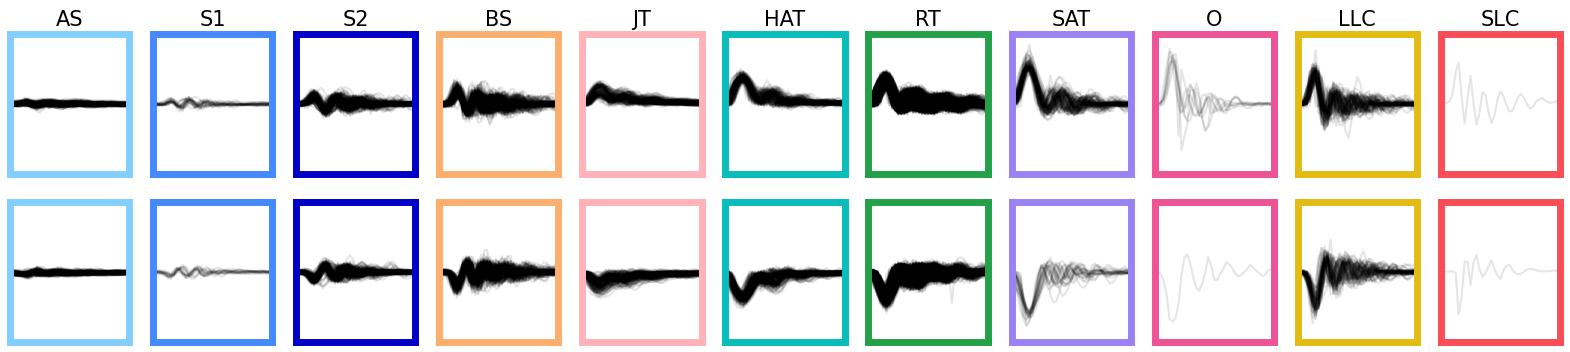

In [71]:
id_b = np.unique(cat[proba>0.8]).astype('int')

fig, ax = plt.subplots(facecolor='white',figsize=(20,4)) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
G = gridspec.GridSpec(2,len(id_b))
ax0 = {}
for i,b in enumerate(id_b):
    ax0 = plt.subplot(G[0,i])
    ax0.set_title(bouts_category_name_short[b],fontsize=15) 
    for i_sg,sg in enumerate([1,-1]):        
        #ax0.set_title(NameCat[b%11])
        ax0 = plt.subplot(G[i_sg,i])
        id = np.where((cat==b) & (sign==sg)&(proba>0.8))[0]
        if len(id)>0:
            for j in id:
                on_ = int(first_half_beat[j])-6
                if on_>0:
                    ax0.plot(tail_array[j,7,on_:].T,color='k',alpha=.1)
                    #ax0.plot(left_fin[j,on_:].T,color='k',alpha=.1)
        ax0.set_xlim(0,segmentation_cfg.bout_duration)
        ax0.set_ylim(-6,6)
        ax0.set_xticks([])
        ax0.set_yticks([])
        for sp in ['top','bottom','left','right']:
            ax0.spines[sp].set_color(bouts_category_color[b])
            ax0.spines[sp].set_linewidth(5)

plt.show()

# Resample at 700fps

In [72]:
from scipy import interpolate
from scipy.signal import savgol_filter

t = np.linspace(0,200,40,endpoint=True)
tnew = np.linspace(0,200,140,endpoint=True)
N = tail_array.shape[0]

tail_array_up = np.zeros((tail_array.shape[0],10,140))

for i in range(N):
    for n in range(10):
        y = tail_array[i,n,:40]
        f = interpolate.interp1d(t, y)
        ynew = f(tnew)   
        savgol_window = 15
        y_smooth = savgol_filter(ynew,savgol_window, 2, deriv=0, delta=1.0, axis=-1,mode='interp', cval=0.0)
        tail_array_up[i,n,:] = y_smooth
        
        
body_up = np.zeros((N, 140))
left_eye_up = np.zeros((N, 140))
right_eye_up = np.zeros((N, 140))
left_fin_up = np.zeros((N, 140))
right_fin_up = np.zeros((N, 140))

for x,x_up in zip([body,left_eye,right_eye,left_fin,right_fin],[body_up,left_eye_up,right_eye_up,left_fin_up,right_fin_up]):
    for i in range(N):
        y = x[i,:40]
        f = interpolate.interp1d(t, y)
        ynew = f(tnew) 
        savgol_window = 15
        y_smooth = savgol_filter(ynew,savgol_window, 2, deriv=0, delta=1.0, axis=-1,mode='interp', cval=0.0)
        x_up[i,:] = y_smooth
        

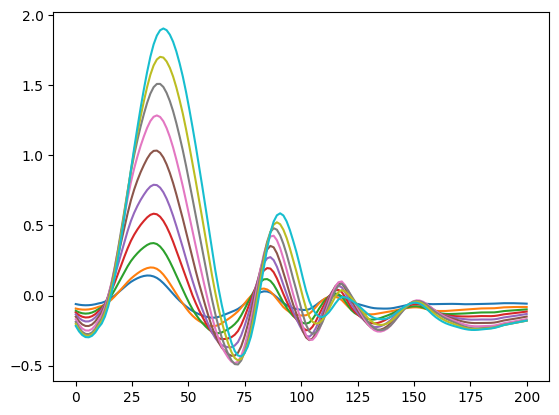

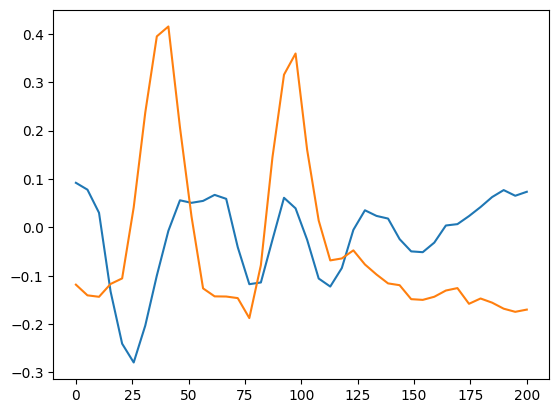

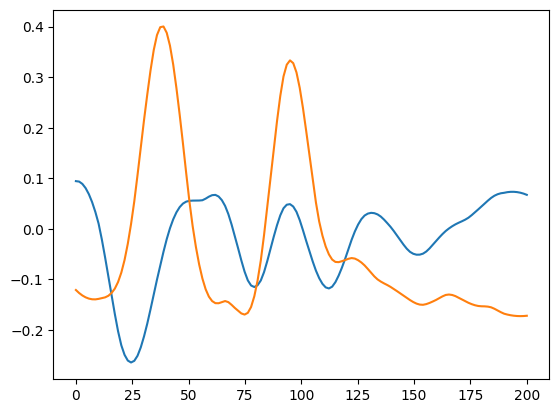

In [73]:
i = np.random.randint(N)
plt.plot(tnew,tail_array_up[i,:,:].T)
plt.show()

plt.plot(t,left_fin[i,:40])
plt.plot(t,right_fin[i,:40])
plt.show()

plt.plot(tnew,left_fin_up[i,:])
plt.plot(tnew,right_fin_up[i,:])
plt.show()

## Add Padding + Noise

In [74]:
tail_array_up.shape

(11063, 10, 140)

In [75]:
tail_array_final = np.zeros((tail_array_up.shape[0],10,200))
for i in range(tail_array_up.shape[0]):
    for n in range(10):
        y = tail_array_up[i,n,:]
        y = np.concatenate([np.zeros(60,)*y[0],y])
        y = y+.01*np.random.randn(len(y))*(n+1)
        tail_array_final[i,n,:] = y

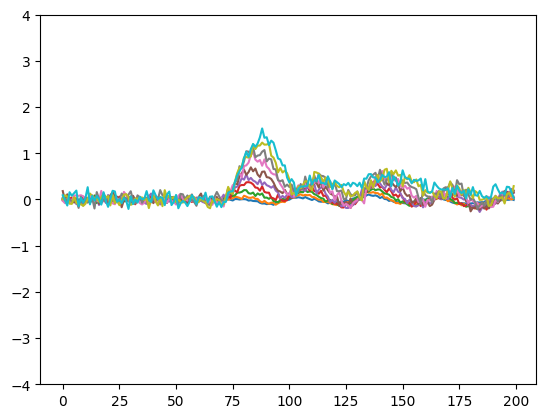

In [76]:
i = np.random.randint(tail_array_final.shape[0])
plt.plot(tail_array_final[i,:,:].T)
plt.ylim(-4,4)
plt.show()

In [77]:
np.save('tail_array_700fps.npy',tail_array_final)

# Classify Upsampled Data

In [78]:
tail_array = np.copy(tail_array_final[:,:,50:-10])
traj_array = np.zeros((N,3,140))*np.nan
#traj_array[:,2,:] = body_up

In [79]:
tail_array.shape

(11063, 10, 140)

In [80]:
tracking_cfg = TrackingConfig(fps=700, tracking='full_tracking')
segmentation_cfg = TailSegmentationConfig(fps=700)
classifier = BoutClassifier(tracking_cfg,segmentation_cfg,exclude_CS=True,device=device)
classif_results = classifier.run_classification(tail_array=tail_array,
                                                traj_array=traj_array)
cat = classif_results['cat']
subcat = classif_results['subcat']
sign = classif_results['sign']
proba = classif_results['proba']
first_half_beat = classif_results['first_half_beat']

/Users/katharinakotter/miniconda3/envs/megabouts/lib/python3.11/site-packages/megabouts/classification/classification.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t

In [81]:
my_dict ={}

my_dict['label_names'] = bouts_category_name
my_dict['category'] = cat
my_dict['sub_category'] = subcat

In [82]:
import flammkuchen as fl

In [83]:
fl.save(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data\megabouts_clusters_rerun.h5', my_dict)

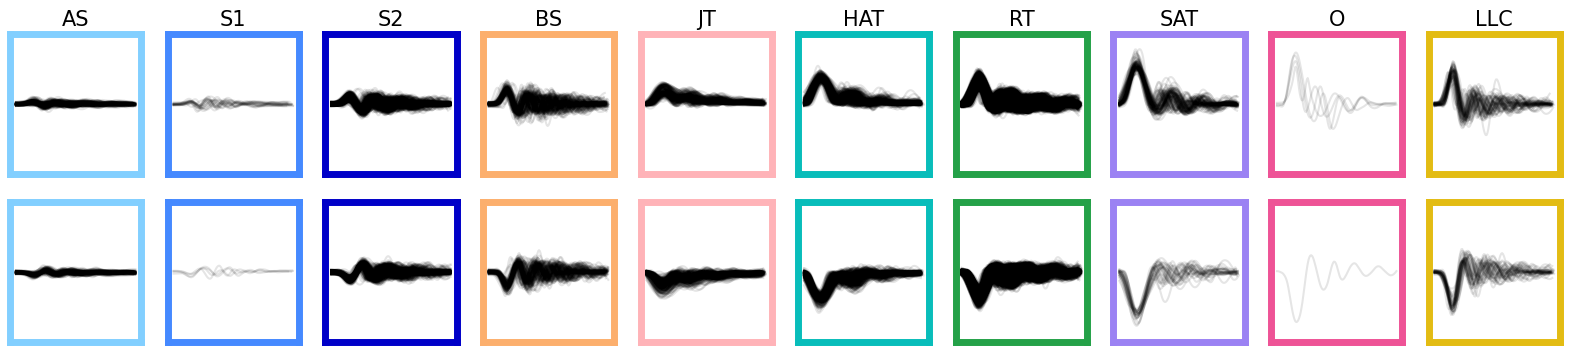

In [84]:
id_b = np.unique(cat[proba>0.8]).astype('int')

fig, ax = plt.subplots(facecolor='white',figsize=(20,4)) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
G = gridspec.GridSpec(2,len(id_b))
ax0 = {}
for i,b in enumerate(id_b):
    ax0 = plt.subplot(G[0,i])
    ax0.set_title(bouts_category_name_short[b],fontsize=15) 
    for i_sg,sg in enumerate([1,-1]):        
        #ax0.set_title(NameCat[b%11])
        ax0 = plt.subplot(G[i_sg,i])
        id = np.where((cat==b) & (sign==sg)&(proba>0.8))[0]
        if len(id)>0:
            for j in id:
                on_ = int(first_half_beat[j])-30
                if on_>0:
                    ax0.plot(tail_array_up[j,7,on_:].T,color='k',alpha=.1)
                    #ax0.plot(left_fin[j,on_:].T,color='k',alpha=.1)
        ax0.set_ylim(-6,6)
        ax0.set_xticks([])
        ax0.set_yticks([])
        for sp in ['top','bottom','left','right']:
            ax0.spines[sp].set_color(bouts_category_color[b])
            ax0.spines[sp].set_linewidth(5)

plt.savefig(Path( save_figure_path/ 'bout_traces_megabouts_res.png'), dpi=350)